# Potato Disease Classification

### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

KeyboardInterrupt: 

### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/ritiksingh/Downloads/LuffaFolio A Multifaceted Luffa Aegyptiaca Image Dataset/Resized Dataset/Smooth_Luffa_Dataset_224",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1933 files belonging to 3 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [ ]:
class_names = dataset.class_names
class_names

['Flower_224', 'Luffa_Diseases_224', 'Luffa_Grade_224']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 2 2 0 1 1 1 1 1 0 2 1 2 0 1 1 2 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1]


2024-04-21 23:13:08.576544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

2024-04-21 23:13:09.442415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


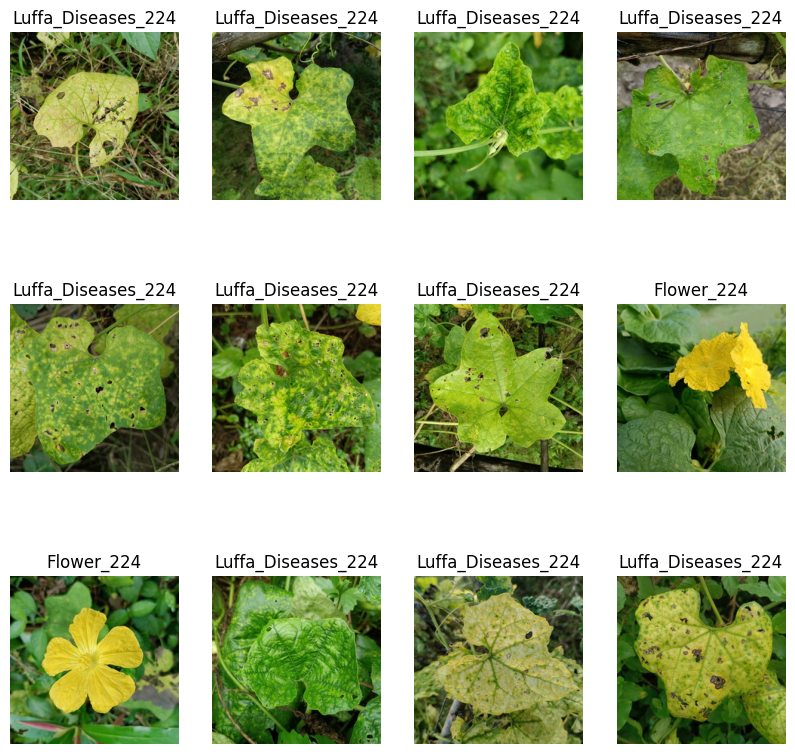

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

61

In [ ]:
train_size = 0.8
len(dataset)*train_size

48.800000000000004

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

7

In [ ]:
val_size=0.1
len(dataset)*val_size

6.1000000000000005

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

1

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

48

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

7

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/Users/ritiksingh/anaconda3/envs/deeplearn/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Trial 10 Complete [00h 10m 44s]
val_accuracy: 0.6975609660148621

Best val_accuracy So Far: 0.9756097793579102
Total elapsed time: 02h 50m 29s
/Users/ritiksingh/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:394: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
[1m6/6[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m7s[0m 637ms/step - accuracy: 0.9578 - loss: 0.1363
Test accuracy: 0.9583333134651184

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,459 (669.76 KB)

 Trainable params: 171,459 (669.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
import os
import tensorflow as tf

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = INFO messages, 2 = INFO + WARNING messages, 3 = ERROR messages

def print_epoch_info(epoch, logs):
    # Print custom epoch training batch information
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Batch - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

# Assuming `model`, `train_ds`, `val_ds`, and `BATCH_SIZE` are defined earlier

EPOCHS = 25 # Adjust this value as needed

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if validation loss doesn't improve after 5 epochs
    restore_best_weights=True  # Restore model weights with best validation loss
)

# Define a callback to print custom epoch information
custom_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=print_epoch_info)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,  # Set verbose=0 to suppress the default progress bar
    epochs=EPOCHS,
    callbacks=[early_stopping, custom_callback]
)


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6531 - loss: 0.8932Epoch 1/25
Batch - loss: 0.7557 - accuracy: 0.6875 - val_loss: 0.5227 - val_accuracy: 0.7604
48/48 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.6538 - loss: 0.8904 - val_accuracy: 0.7604 - val_loss: 0.5227
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7621 - loss: 0.5329Epoch 2/25
Batch - loss: 0.4950 - accuracy: 0.7851 - val_loss: 0.3488 - val_accuracy: 0.8646
48/48 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.7626 - loss: 0.5321 - val_accuracy: 0.8646 - val_loss: 0.3488
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8363 - loss: 0.4012Epoch 3/25
Batch - loss: 0.3987 - accuracy: 0.8392 - val_loss: 0.3007 - val_accuracy: 0.8802
48/48 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8364 - loss: 0.4012 - val_accuracy: 0.8802 - val_loss: 0.3007
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8577 - loss: 0.3457Epoch 4/25
Batch - loss: 0.3171 - accuracy: 0

In [ ]:
scores = model.evaluate(test_ds)

NameError: name 'model' is not defined

**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [ ]:
scores
# [0.14457009732723236, 0.9285714030265808]
#[0.016048220917582512, 0.9955357313156128]

[0.20312538743019104, 0.9107142686843872]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 48}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

15

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8683030605316162,
 0.5413211584091187,
 0.36731866002082825,
 0.3967518210411072,
 0.3733682632446289]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

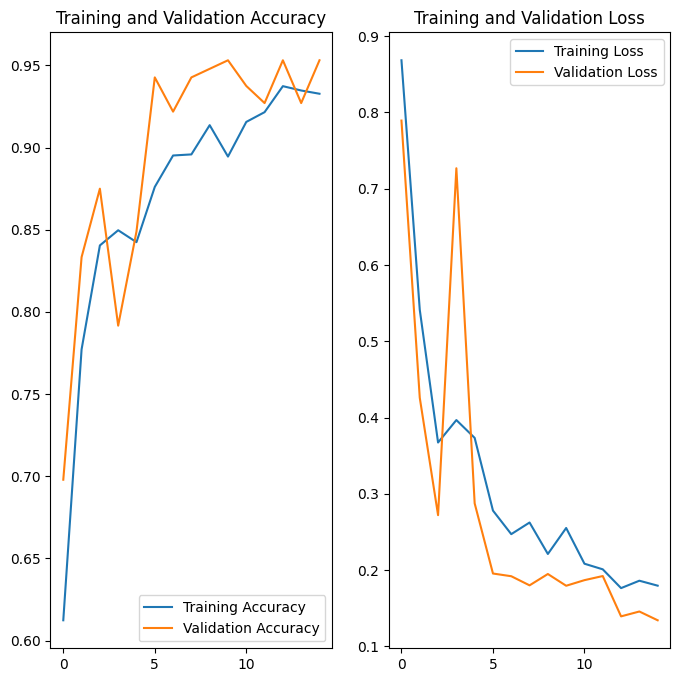

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

import matplotlib.pyplot as plt

# Assuming you have a history object returned by model.fit() stored in a variable called 'history'

plt.figure(figsize=(8, 8))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


### Run prediction on a sample image

first image to predict
actual label: Flower_224
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Flower_224


2024-04-20 01:19:45.095218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


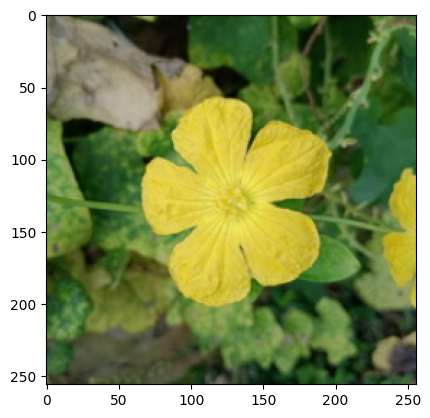

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


2024-04-20 01:19:49.806146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


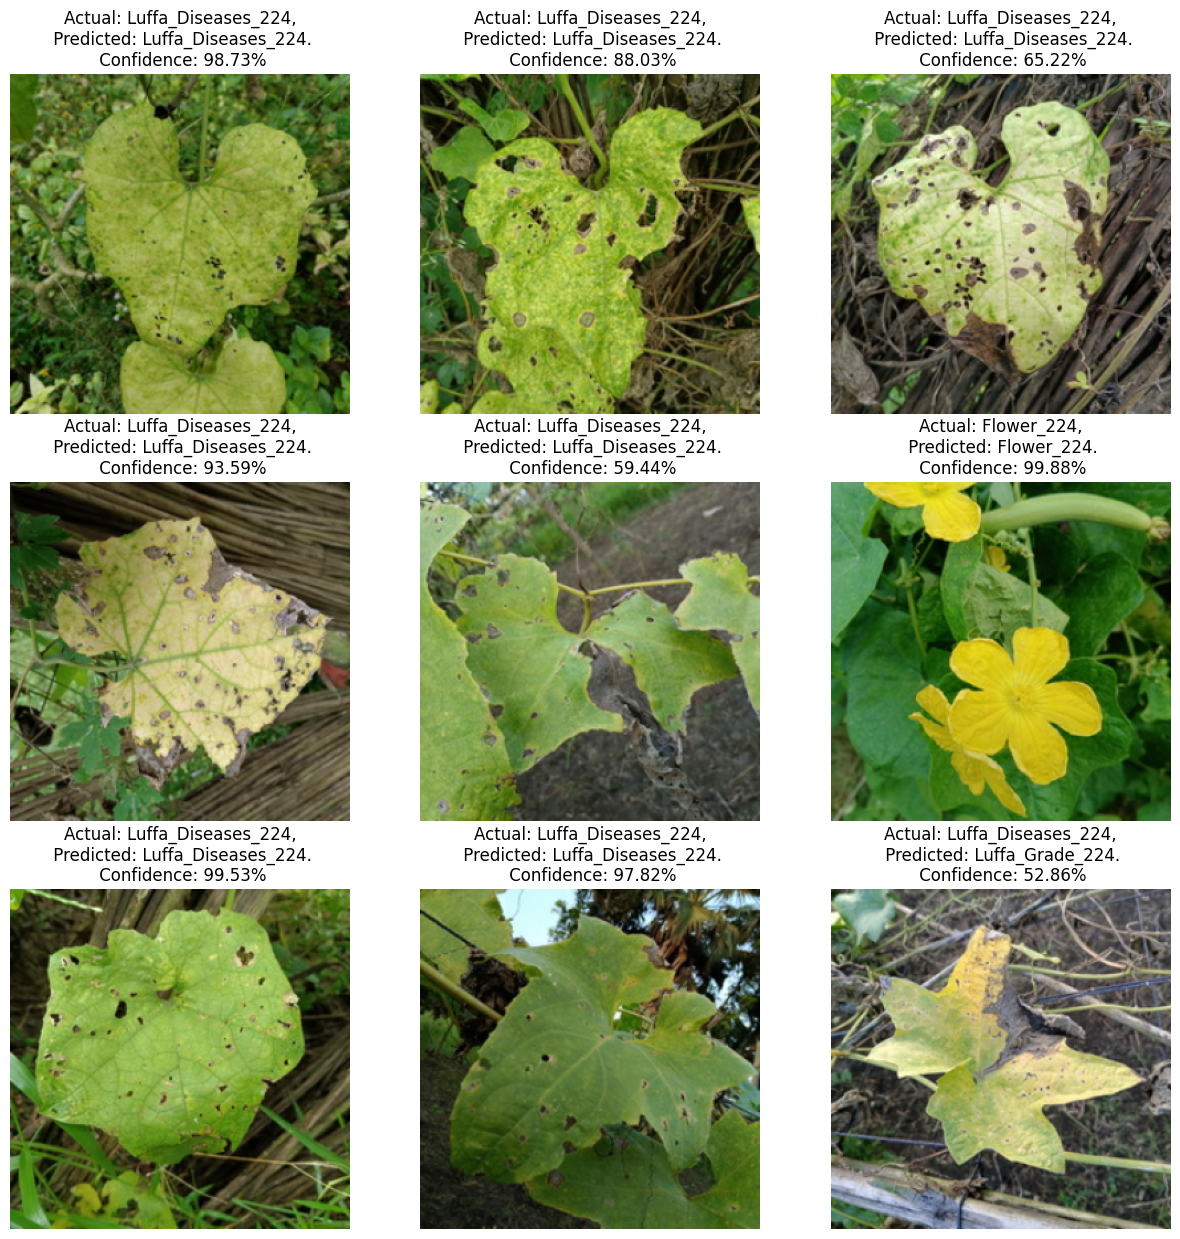

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [ ]:
#model.save("/Users/ritiksingh/Downloads/LUFFADISEASEMODEL.h5")

In [ ]:
# # Define function to pre-process and predict on an image
# def predict(image_path, model):
#   """
#   Loads an image, preprocesses it, and predicts the class using the model.
#   """
#   # (Replace with your preferred pre-processing steps)
#   # Example pre-processing for images of size (224, 224, 3):
#   img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
#   img_array = tf.keras.preprocessing.image.img_to_array(img)
#   img_array = img_array / 255.0  # Normalize pixel values (assuming model expects this)
#   img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

#   # Make prediction using the loaded model
#   predictions = model.predict(img_batch)
#   predicted_class_index = tf.argmax(predictions[0]).numpy()

#   # Assuming you have a list of class names associated with model predictions
#   class_names = ['Flower_224', 'Luffa_Diseases_224', 'Luffa_Grade_224']# Replace with your actual class names

#   # Print the predicted class
#   predicted_class_name = class_names[predicted_class_index]
#   print(f"Predicted class for '{image_path}': {predicted_class_name}")

# # Example usage (assuming model is already loaded)
# test_image_path = "/Users/ritiksingh/Downloads/LuffaFolio A Multifaceted Luffa Aegyptiaca Image Dataset/Resized Dataset/Smooth_Luffa_Dataset_224/Luffa_Grade_224/Freash_224/slFresh-040.jpg"  # Replace with your test image path
# predict(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Predicted class for '/Users/ritiksingh/Downloads/LuffaFolio A Multifaceted Luffa Aegyptiaca Image Dataset/Resized Dataset/Smooth_Luffa_Dataset_224/Luffa_Grade_224/Freash_224/slFresh-040.jpg': Luffa_Grade_224


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model

# # Specify the path to the model file
# MODEL_PATH = '/Users/ritiksingh/Downloads/LUFFADISEASEMODEL.h5'

# # Load the model with compile=False to skip model compilation
# try:
#     model = load_model(MODEL_PATH, compile=False)
# except ValueError as e:
#     print("Error loading the model:", e)

# # Check if model is properly loaded
# if isinstance(model, str):
#     print("Model loading failed. Check the error message above.")
# else:
#     # Use the loaded model for prediction
#     class_names = ['Flower_224', 'Luffa_Diseases_224', 'Luffa_Grade_224']

#     def predict(model, img_path):
#         img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
#         img_array = tf.keras.preprocessing.image.img_to_array(img)
#         img_array = tf.expand_dims(img_array, axis=0)

#         predictions = model.predict(img_array)
#         predicted_class = class_names[tf.argmax(predictions, axis=1).numpy()[0]]
#         confidence = round(100 * tf.reduce_max(predictions).numpy(), 2)
        
#         return predicted_class, confidence

#     # Test the predict function
#     sample_image_path = "/Users/ritiksingh/Downloads/LuffaFolio A Multifaceted Luffa Aegyptiaca Image Dataset/Resized Dataset/Smooth_Luffa_Dataset_224/Luffa_Diseases_224/Holed_224/slHole-004.jpg"
#     predicted_class, confidence = predict(model, sample_image_path)

#     print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicted Class: Luffa_Diseases_224, Confidence: 99.52%


In [ ]:
# import os
# os.path.isfile("/Users/ritiksingh/Downloads/model(codebasics).keras")

True

In [ ]:
# from tensorflow.keras.models import load_model

# # load model 
# model = load_model('/Users/ritiksingh/Downloads/LUFFADISEASEMODEL.h5')

# # check model info 
# model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,749 (717.77 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.8/686.8 kB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.3 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 2.0 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.0 MB/s eta 0:00:0000:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 960.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 679.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [8]:
tensorflowjs_converter -input_format ==keras \
                       /Users/ritiksingh/Downloads/luffamodel8.h5 \
                       /Users/ritiksingh/Downloads/potato-disease-classification-main


NameError: name 'tensorflowjs_converter' is not defined